<a href="https://colab.research.google.com/github/khchoi-physik/autoencoders/blob/main/minst_autoencoder_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, RandomTranslation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [86]:
from tensorflow.keras.datasets import mnist

(x_train, y_train) , (x_test, y_test) = mnist.load_data()

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
5


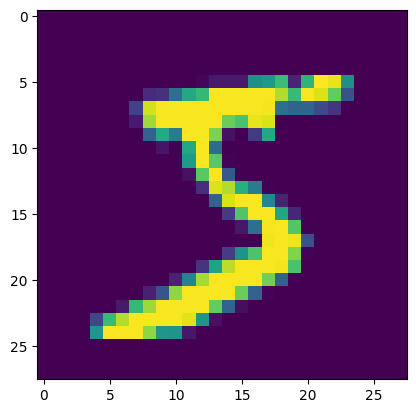

In [87]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.imshow(x_train[0])
print(y_train[0])

In [88]:
print(np.max(x_train[0]))
print(np.min(x_train[0]))
print(x_train.shape)

255
0
(60000, 28, 28)


In [89]:
x_train = np.expand_dims(x_train.astype('float32')/255. , -1)
x_test = np.expand_dims(x_test.astype('float32')/255. , -1)

valid_ratio = x_train.shape[0] * 0.9

x_valid = x_train[int(valid_ratio):]
y_valid = y_train[int(valid_ratio):]

x_train = x_train[:int(valid_ratio)]
y_train = y_train[:int(valid_ratio)]

In [90]:
print(x_train.max(), x_train.min())
print(valid_ratio)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

1.0 0.0
54000.0
(54000, 28, 28, 1) (54000,)
(6000, 28, 28, 1) (6000,)


In [91]:
## data augmentation

data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomFlip('horizontal'),
    RandomTranslation(0.1,0.1)
])

In [92]:
input_mnist = Input(shape=(28,28,1))

In [93]:
## Deep Encoder
# x = data_augmentation(input_mnist)
x = Conv2D(32, (3,3) , activation = 'relu', padding = 'same', name = 'en_cov1')(input_mnist)
x = BatchNormalization( name = 'en_bn1')(x)
x = Conv2D(32, (3,3) , activation = 'relu', padding = 'same', name = 'en_cov2')(x)
x = BatchNormalization( name = 'en_bn2')(x)
x = MaxPooling2D((2,2) , padding = 'same', name = 'en_mp_1')(x)
x = Dropout(0.1, name = 'en_dropout1')(x)

x = Conv2D(64, (3,3) , activation = 'relu', padding = 'same', name = 'en_cov3')(x)
x = BatchNormalization( name = 'en_bn3')(x)
x = Conv2D(64, (3,3) , activation = 'relu', padding = 'same', name = 'en_cov4')(x)
x = BatchNormalization( name = 'en_bn4')(x)
x = MaxPooling2D((2,2) , padding = 'same', name = 'en_mp_2')(x)
x = Dropout(0.1, name = 'en_dropout2')(x)

x = Conv2D(128, (3,3) , activation = 'relu', padding ='same', name = 'en_cov5')(x)
neck = BatchNormalization( name = 'en_bn5')(x)


In [94]:
# Deep Decoder

x = Conv2D(128, (3,3) , activation = 'relu', padding = 'same', name = 'de_cov1')(neck)
x = BatchNormalization( name = 'de_bn1' )(x)
x = UpSampling2D( (2,2) , name = 'de_us1' )(x)

x = Conv2D(64, (3,3) , activation = 'relu', padding = 'same', name = 'de_cov2')(x)
x = BatchNormalization( name = 'de_bn2' )(x)
x = UpSampling2D( (2,2) , name = 'de_us2' )(x)

x = Conv2D(32, (3,3) , activation = 'relu', padding = 'same', name = 'de_cov3')(x)
x = BatchNormalization( name = 'de_bn3' )(x)

output_mnist = Conv2D(1, (3,3) , activation = 'sigmoid', padding = 'same', name = 'result')(x)

In [95]:
## Decoder

# x = Conv2D(64, (3,3) , activation = 'relu', padding = 'same', name = 'de_cov1')(neck)
# x = BatchNormalization( name = 'de_bn1' )(x)
# x = UpSampling2D( (2,2) , name = 'de_us1' )(x)

# x = Conv2D(32, (3,3) , activation = 'relu', padding = 'same', name = 'de_cov2')(x)
# x = BatchNormalization( name = 'de_bn2' )(x)
# x = UpSampling2D( (2,2) , name = 'de_us2' )(x)
# output_mnist = Conv2D(1, (3,3) , activation = 'sigmoid', padding = 'same', name = 'result')(x)

In [96]:
## Classifier

y = Flatten( name = 'cl_flatten')(neck)
y = Dense(128, activation = 'relu', name = 'cl_dense1')(y)
y = Dropout(0.5, name = 'cl_dropout1')(y)
output_label = Dense(10, activation = 'softmax', name = 'classifier')(y)


In [97]:
model = Model( inputs = input_mnist , outputs = [output_mnist, output_label] )

In [98]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_cov1 (Conv2D)          │ (None, 28, 28, 32)     │            320 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_bn1                    │ (None, 28, 28, 32)     │            128 │ en_cov1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_cov2 (Conv2D)          │ (None, 28, 28, 32)     │          9,248 │ en_bn1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_bn2                    │ (None, 28, 28, 32)     │            128 │ en_cov2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_mp_1 (MaxPooling2D)    │ (None, 14, 14, 32)     │              0 │ en_bn2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_dropout1 (Dropout)     │ (None, 14, 14, 32)     │              0 │ en_mp_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_cov3 (Conv2D)          │ (None, 14, 14, 64)     │         18,496 │ en_dropout1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_bn3                    │ (None, 14, 14, 64)     │            256 │ en_cov3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_cov4 (Conv2D)          │ (None, 14, 14, 64)     │         36,928 │ en_bn3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_bn4                    │ (None, 14, 14, 64)     │            256 │ en_cov4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_mp_2 (MaxPooling2D)    │ (None, 7, 7, 64)       │              0 │ en_bn4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_dropout2 (Dropout)     │ (None, 7, 7, 64)       │              0 │ en_mp_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_cov5 (Conv2D)          │ (None, 7, 7, 128)      │         73,856 │ en_dropout2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ en_bn5                    │ (None, 7, 7, 128)      │            512 │ en_cov5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ de_cov1 (Conv2D)          │ (None, 7, 7, 128)      │        147,584 │ en_bn5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ de_bn1               

 Total params: 1,185,387 (4.52 MB)

 Trainable params: 1,184,299 (4.52 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [99]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)

model.compile(
    optimizer = 'adam',
    loss = ['binary_crossentropy','sparse_categorical_crossentropy'],
    loss_weights=[1,1],
    metrics = {'classifier': 'accuracy'})

In [100]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_minst.keras', monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]

In [101]:
history = model.fit(x_train, [x_train, y_train],
                    epochs=100,
                    batch_size=64,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_data=(x_valid, [x_valid, y_valid]))

Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - classifier_accuracy: 0.8837 - classifier_loss: 0.3915 - loss: 0.5656 - result_loss: 0.1742
Epoch 1: val_loss improved from inf to 0.13301, saving model to best_minst.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - classifier_accuracy: 0.8837 - classifier_loss: 0.3912 - loss: 0.5653 - result_loss: 0.1741 - val_classifier_accuracy: 0.9862 - val_classifier_loss: 0.0554 - val_loss: 0.1330 - val_result_loss: 0.0774 - learning_rate: 0.0010
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - classifier_accuracy: 0.9763 - classifier_loss: 0.0851 - loss: 0.1636 - result_loss: 0.0785
Epoch 2: val_loss improved from 0.13301 to 0.11378, saving model to best_minst.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - classifier_accuracy: 0.9763 - classifier_loss: 0.0851 - loss: 0.1636 - result_loss: 0.0785 - val_classifier_accuracy: 0.9887 - val_classifier_loss: 0.0384 - val_loss: 0.1138 - val_result_loss: 0.0753 - learning_rate: 0.0010
Ep

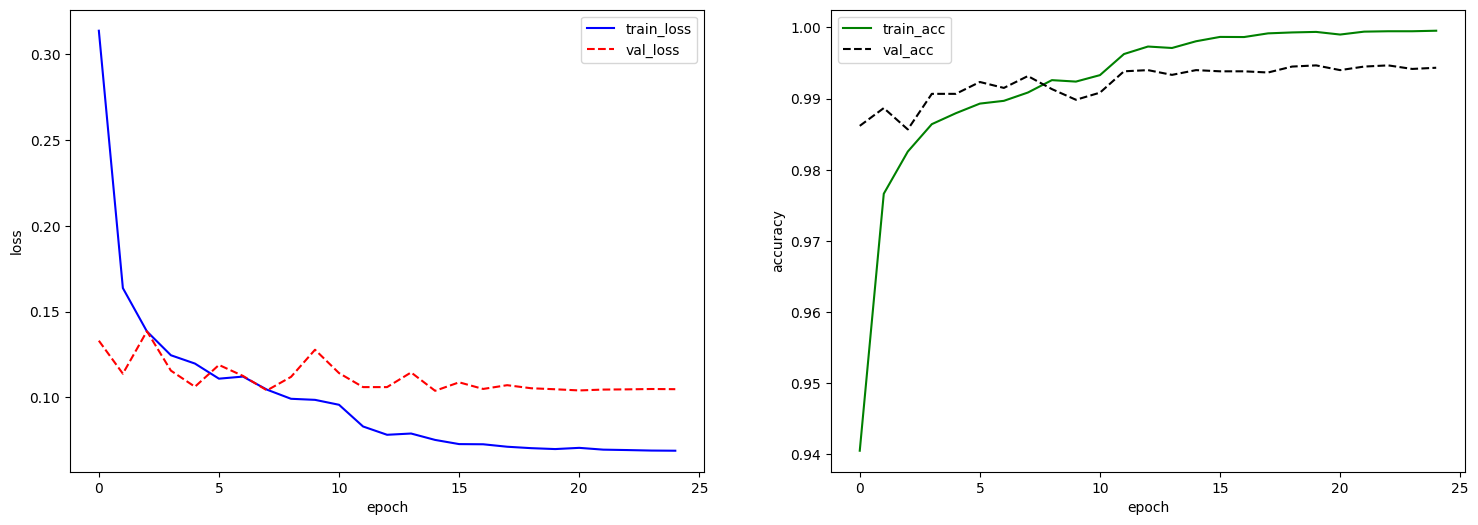

In [102]:
plt.figure( figsize = (18,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'train_loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['classifier_accuracy'], 'g-', label = 'train_acc')
plt.plot(history.history['val_classifier_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [103]:
test_result = model.evaluate(x_test, [x_test, y_test], batch_size=128)


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - classifier_accuracy: 0.9949 - classifier_loss: 0.0232 - loss: 0.0893 - result_loss: 0.0660


In [104]:
print(f"total loss = {test_result[0]} \n",
      f"reconstruction loss = {test_result[1]} \n",
      f"classification loss = {test_result[2]} \n",
      f"accuracy = {test_result[3]} \n")

total loss = 0.08506479114294052 
 reconstruction loss = 0.06670358777046204 
 classification loss = 0.01811862923204899 
 accuracy = 0.9962000250816345 



In [ ]:
# without callbacks e.g. reduce_lr and early_stopping
# total loss = 0.12471675872802734
# reconstruction loss = 0.07059846073389053
# classification loss = 0.05346132069826126
# accuracy = 0.9865999817848206

# + with callbacks
# total loss = 0.10212152451276779
#  reconstruction loss = 0.0706731453537941
#  classification loss = 0.031056253239512444
#  accuracy = 0.9900000095367432

# + with batch normalization
# total loss = 0.09924779832363129
#  reconstruction loss = 0.07048716396093369
#  classification loss = 0.028398001566529274
#  accuracy = 0.9916999936103821


# + with small dropout
# total loss = 0.09738469123840332
#  reconstruction loss = 0.07138974219560623
#  classification loss = 0.025654137134552002
#  accuracy = 0.9915000200271606


# + deep network
# total loss = 0.08506479114294052
#  reconstruction loss = 0.06670358777046204
#  classification loss = 0.01811862923204899
#  accuracy = 0.9962000250816345


# + augmentation!!
# total loss = 0.2133064717054367
#  reconstruction loss = 0.17323105037212372
#  classification loss = 0.03953130170702934
#  accuracy = 0.9882000088691711
